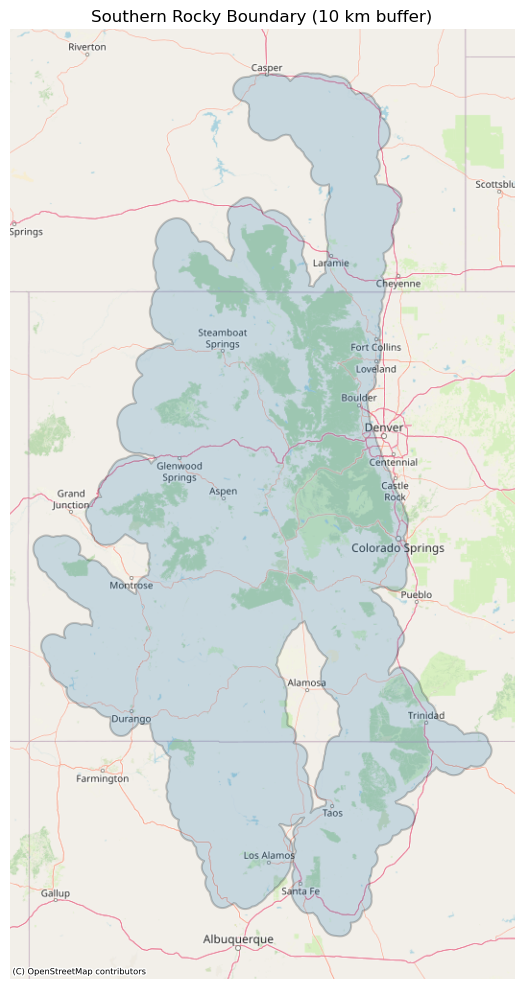

In [11]:
# pip install contextily geopandas matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

region_path = "../../stressors-order-duration-frequency-intensity-innovation-summit-2025__2/SouthernRockyBoundary_10kmBuff.shp"

# read and reproject to web mercator for web tiles
gdf = gpd.read_file(region_path)
gdf_3857 = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# plot your shapes first
gdf_3857.plot(ax=ax, edgecolor="black", linewidth=1.5, alpha = 0.2)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    attribution_size=6
)

ax.set_axis_off()
ax.set_title("Southern Rocky Boundary (10 km buffer)", fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
tiff_path ="../../home/atarano/NLDC_CheesmanLake/"

import glob

# recursive search for all .tiff or .tif files
tiff_files = glob.glob(tiff_path + "/*.tif", recursive=True) + glob.glob(tiff_path + "/*.tiff", recursive=True)

for f in tiff_files:
    print(f)

# !pwd

../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2002_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2013_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2014_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2016_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2023_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2024_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2003_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2007_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2012_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2018_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NLDC_CheesmanLake/Annual_NLCD_LndCov_2020_CU_C1V1_mfywkdxujh4lbb.tiff
../../home/atarano/NL

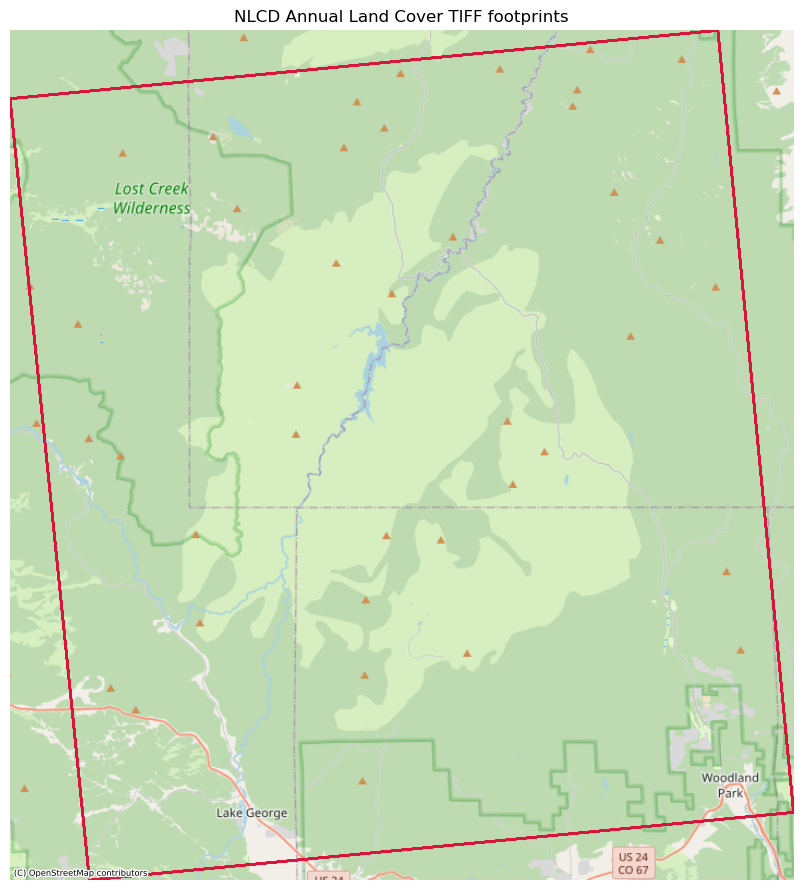

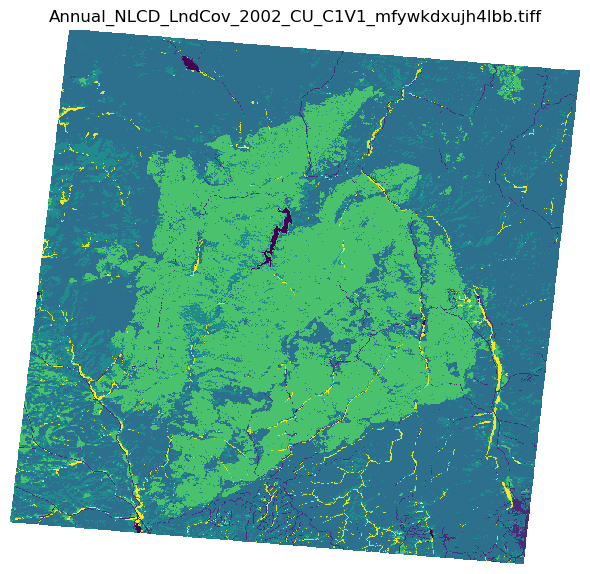

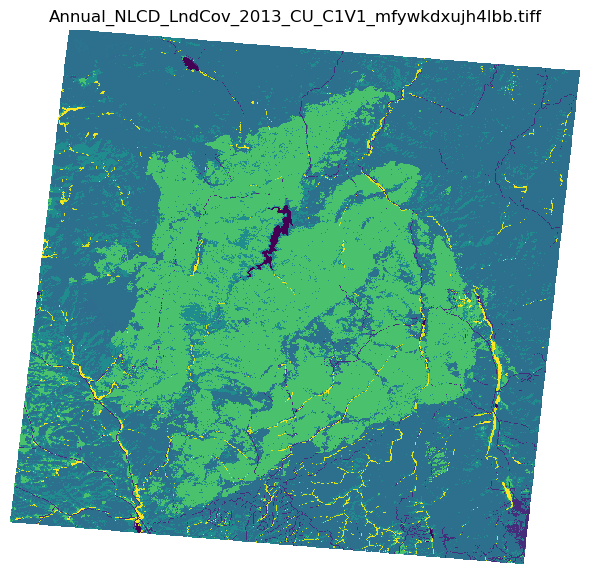

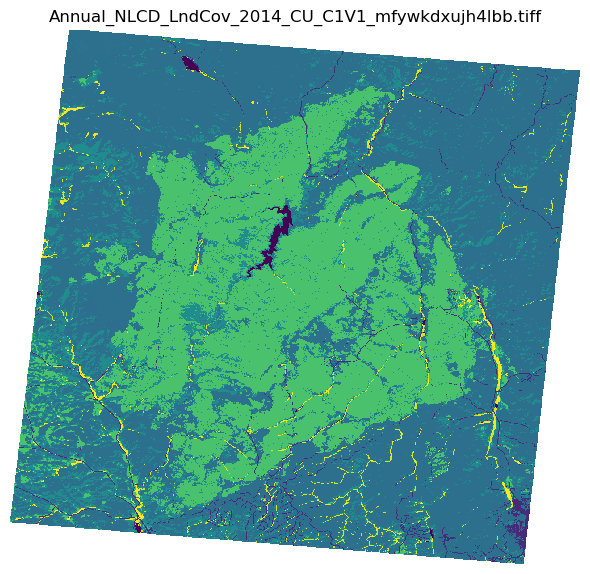

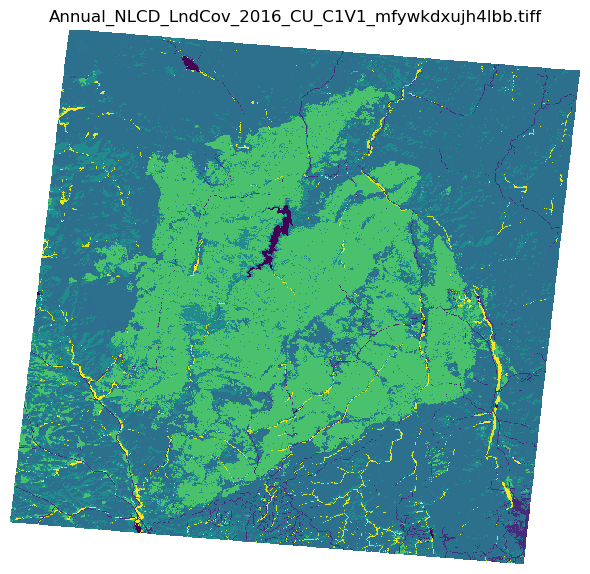

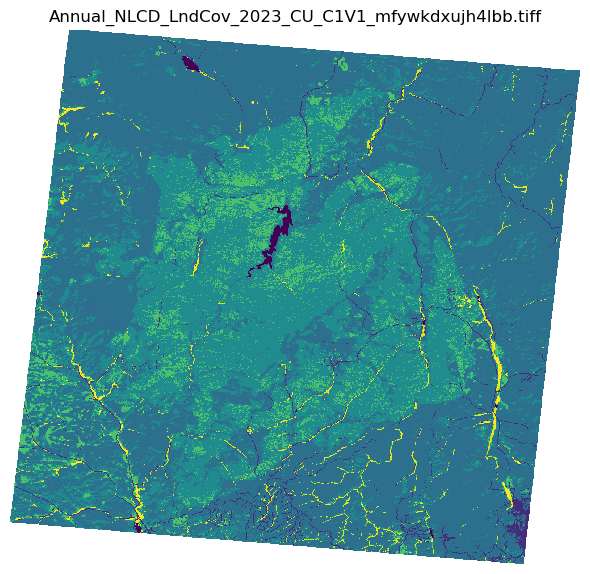

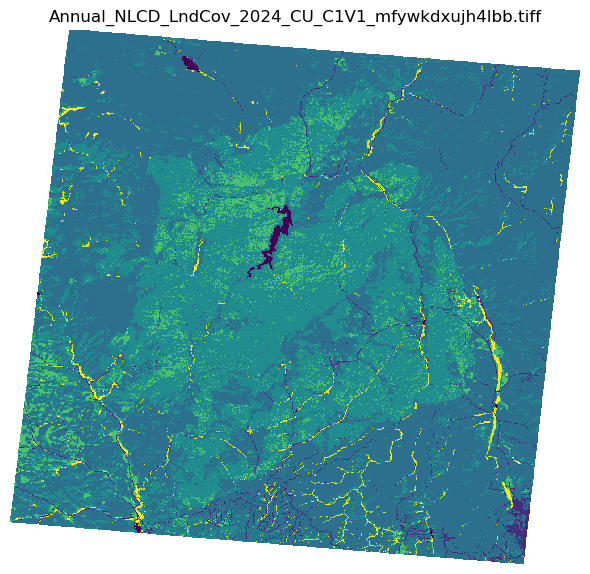

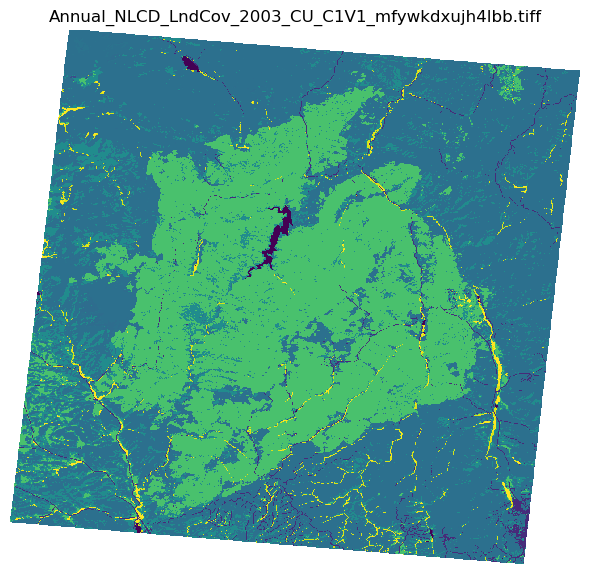

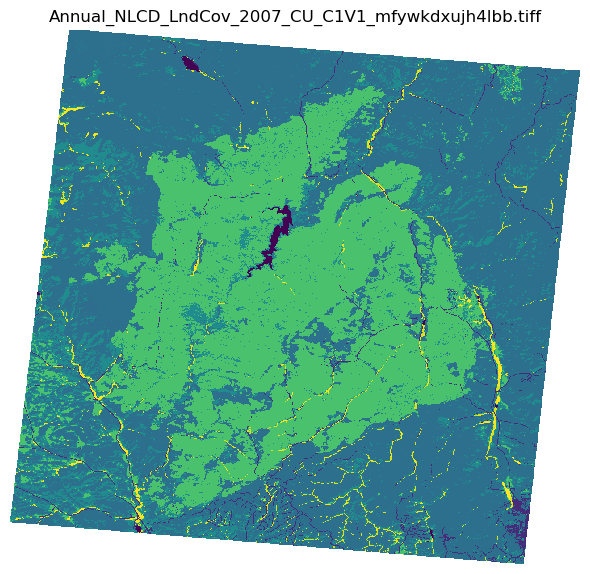

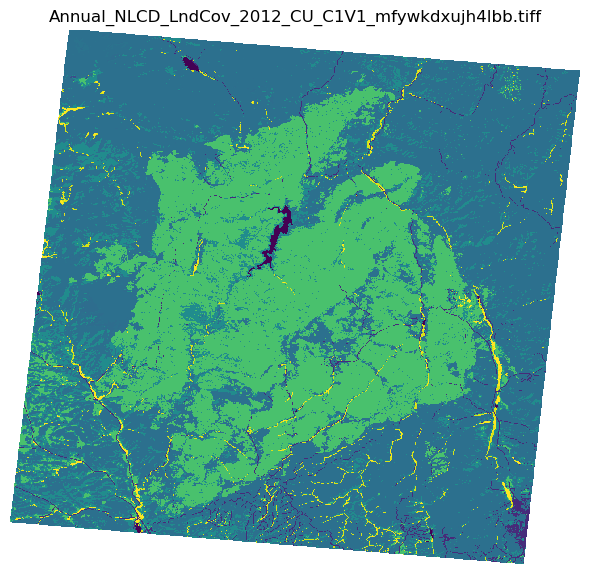

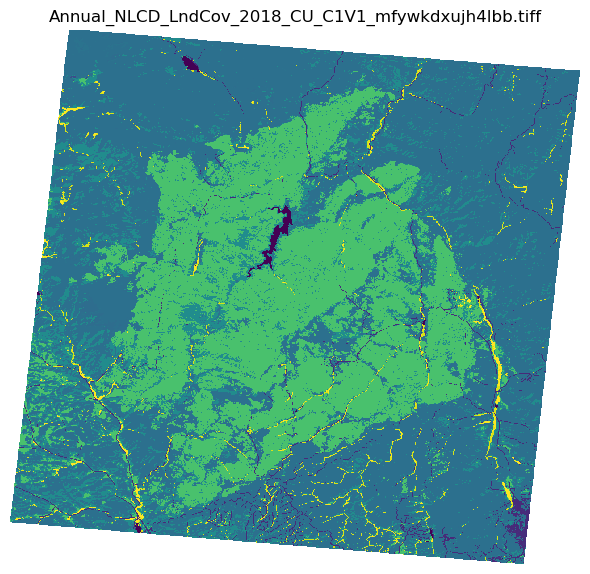

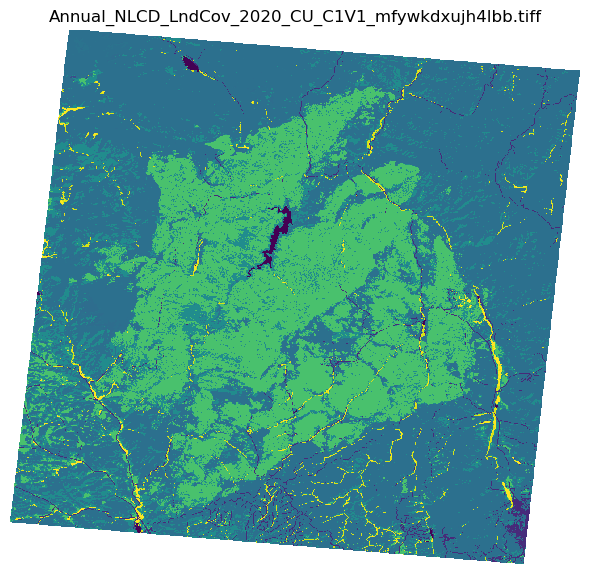

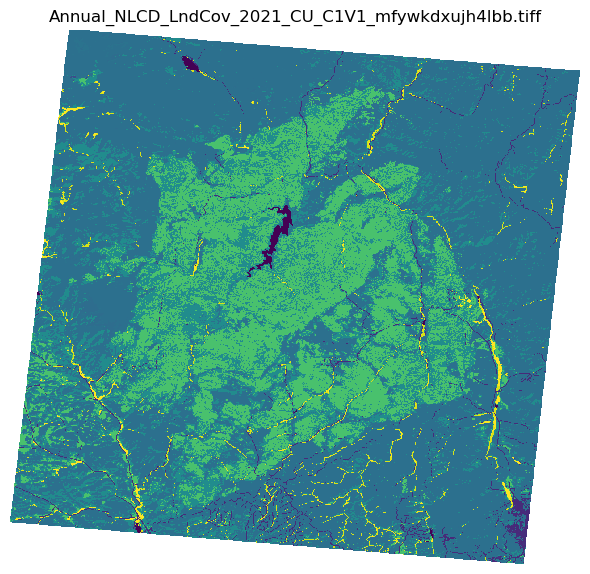

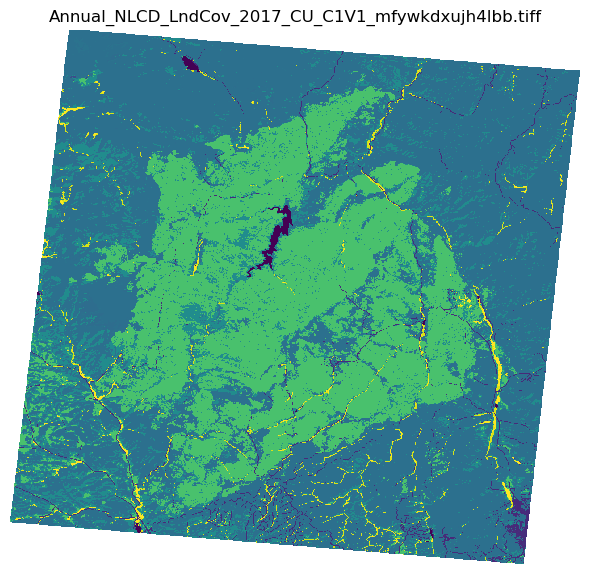

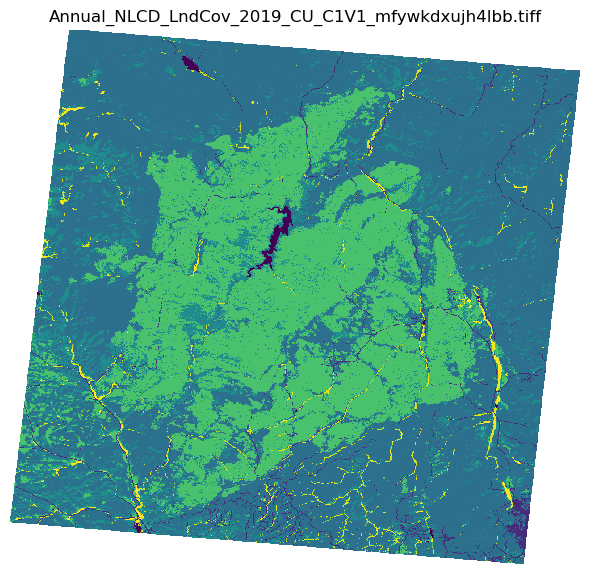

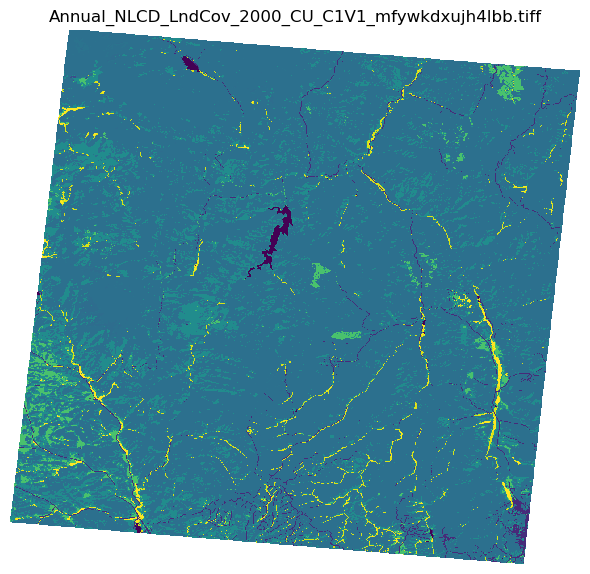

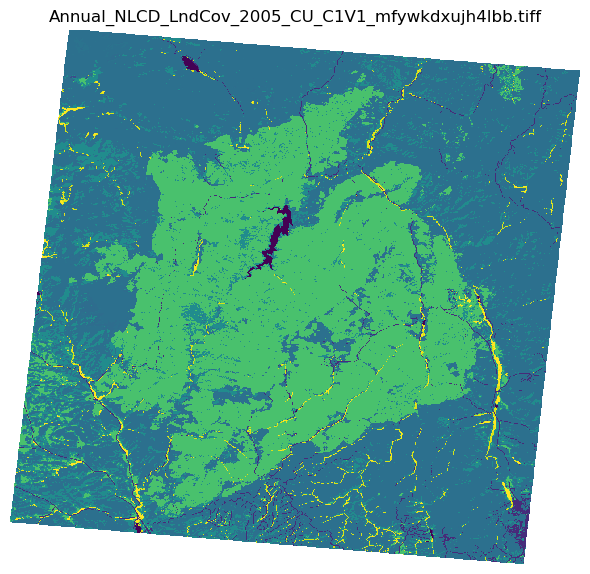

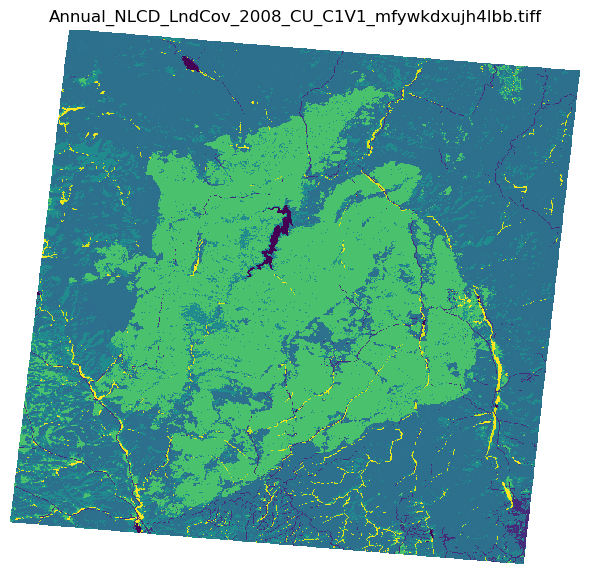

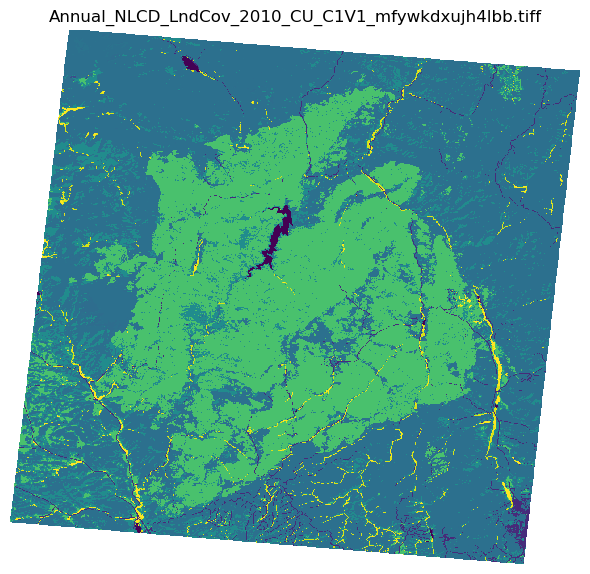

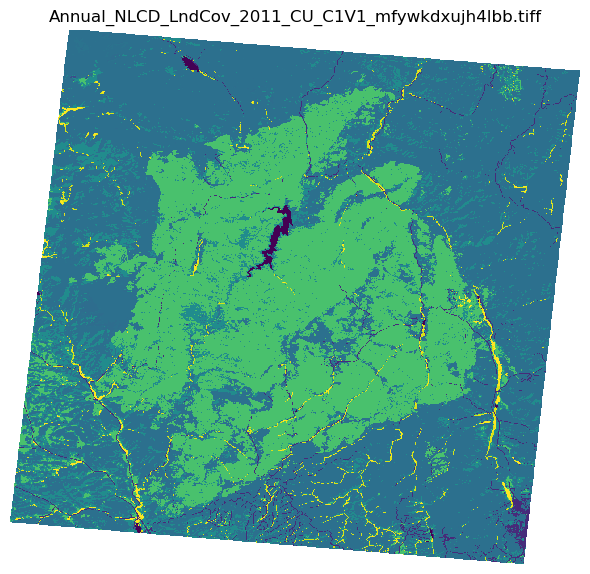

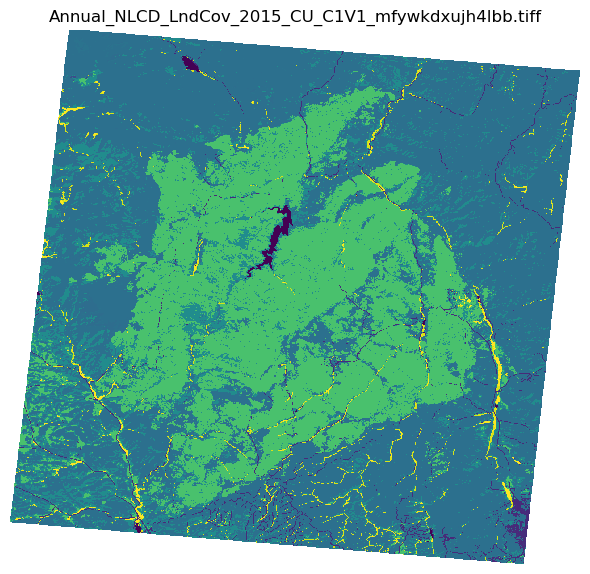

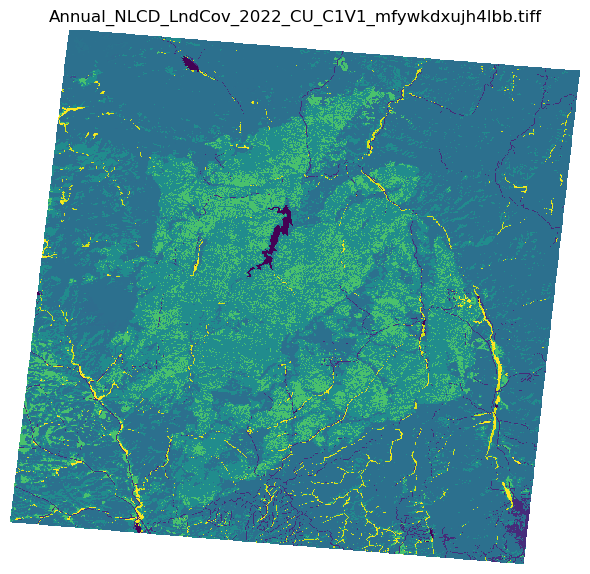

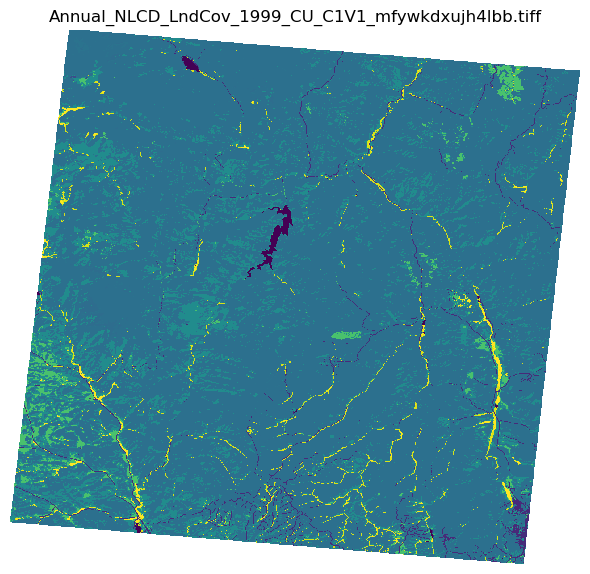

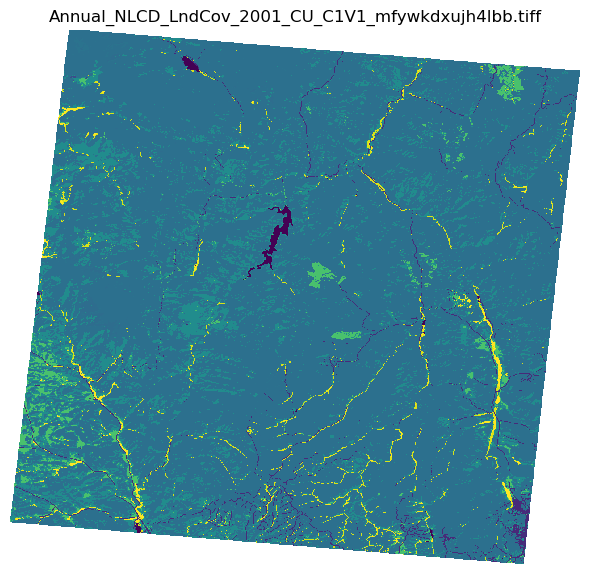

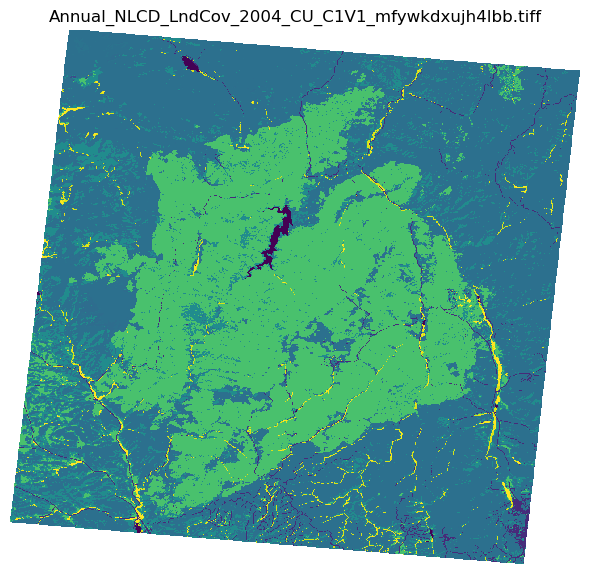

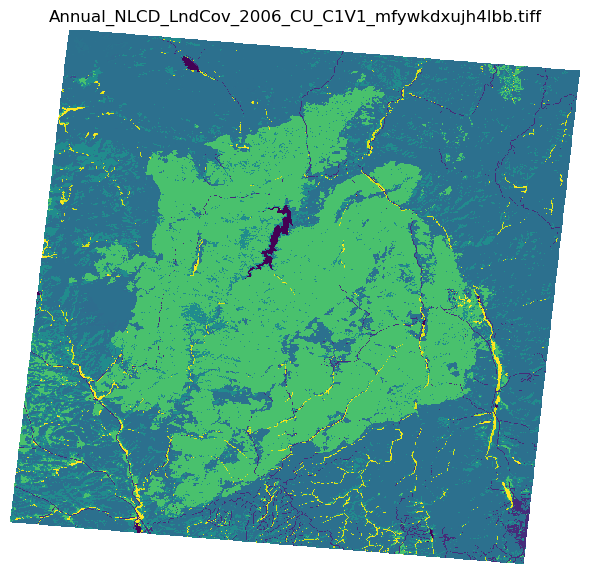

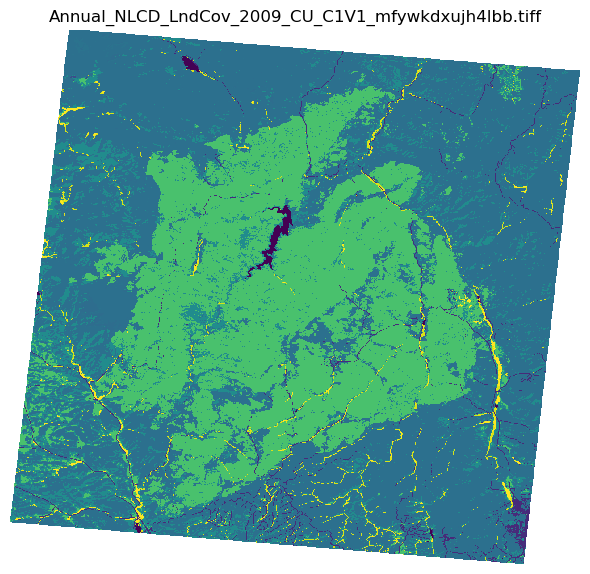

In [25]:
# pip install geopandas rasterio rioxarray shapely contextily matplotlib

import re
from pathlib import Path

import geopandas as gpd
import rasterio
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as cx
import rioxarray as rxr

# Extract year from filenames like "Annual_NLCD_LndCov_2001_..."
def infer_year(p: Path):
    m = re.search(r"(\d{4})", p.name)
    return int(m.group(1)) if m else None

records = []
geoms = []

for p in map(Path, tiff_files):
    with rasterio.open(p.as_posix()) as src:
        # read nothing yet—just metadata to build the footprint
        left, bottom, right, top = src.bounds
        geom = box(left, bottom, right, top)        # polygon in raster CRS
        geoms.append(geom)

        res_x, res_y = src.res
        records.append({
            "path": p.as_posix(),
            "year": infer_year(p),
            "crs_wkt": src.crs.to_wkt() if src.crs else None,
            "crs_epsg": src.crs.to_epsg() if src.crs else None,
            "width_px": src.width,
            "height_px": src.height,
            "res_x": res_x,
            "res_y": res_y,
            "nodata": src.nodata,
        })

# Build GeoDataFrame in the rasters’ native CRS (assumes they share one; NLCD is usually EPSG:5070)
# If some have different CRSs, you can reproject each geometry to a common CRS before constructing the GeoDataFrame.
native_crs = rasterio.open(tiff_files[0]).crs if tiff_files else None
gdf = gpd.GeoDataFrame(records, geometry=geoms, crs=native_crs)

# ---- Save the GeoDataFrame (footprints) to a GeoPackage for later use ----
gdf.to_file("nlcd_footprints.gpkg", layer="footprints", driver="GPKG")

# ---- Plot footprints over an OSM basemap ----
gdf_3857 = gdf.to_crs(epsg=3857)  # Web Mercator for web tiles
fig, ax = plt.subplots(figsize=(9, 9))
gdf_3857.plot(ax=ax, edgecolor="crimson", facecolor="none", linewidth=1.5)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, attribution_size=6)
ax.set_axis_off()
ax.set_title("NLCD Annual Land Cover TIFF footprints", fontsize=12)
# make sure extent fits your data
ax.set_xlim(*gdf_3857.total_bounds[[0, 2]])
ax.set_ylim(*gdf_3857.total_bounds[[1, 3]])
plt.tight_layout()
plt.show()

# This reads the data (can be memory-heavy if rasters are large).
for p in map(Path, tiff_files):
    xarr = rxr.open_rasterio(p.as_posix(), masked=True).squeeze()
    # NLCD is categorical; simple imshow without palette is fine for sanity check
    fig, ax = plt.subplots(figsize=(6, 6))
    xarr.plot.imshow(ax=ax, add_colorbar=False)
    ax.set_title(p.name)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

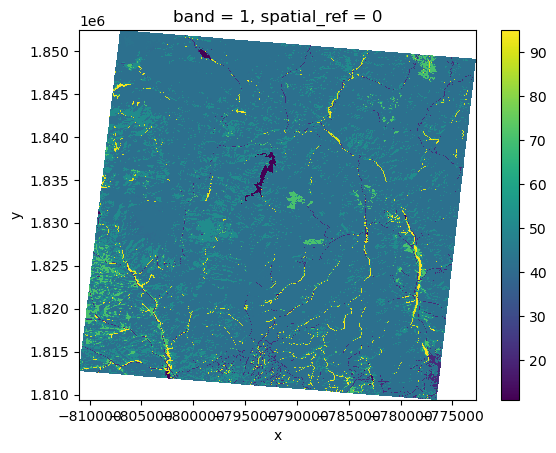

In [26]:
def read_raster(tif_name):
    # open the .tif file from the zip
    with zip_file.open(tif_name) as tif_file:
        # read the file into memory as bytes
        tif_bytes = io.BytesIO(tif_file.read())
        # open the raster 
        raster = rxr.open_rasterio(tif_bytes, masked=True)
    return raster

import re

rasters = {}

for p in map(Path, tiff_files):
    year = re.search(r"(\d{4})", p.name).group(1)  # extract 2001, 2002, etc.
    with rasterio.open(p) as src:
        rasters[year] = rxr.open_rasterio(p.as_posix(), masked=True).squeeze()

rasters["2001"].plot.imshow()

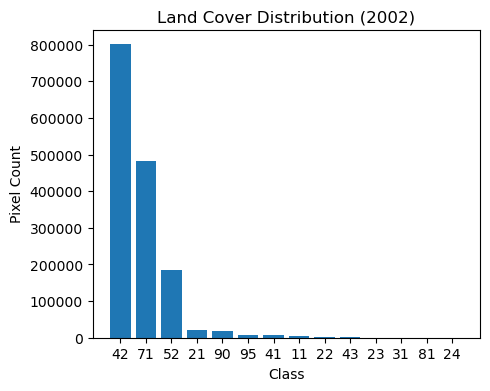

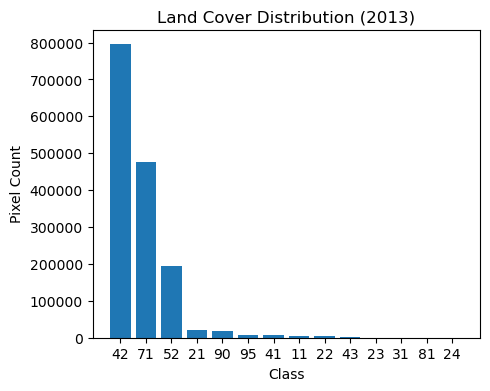

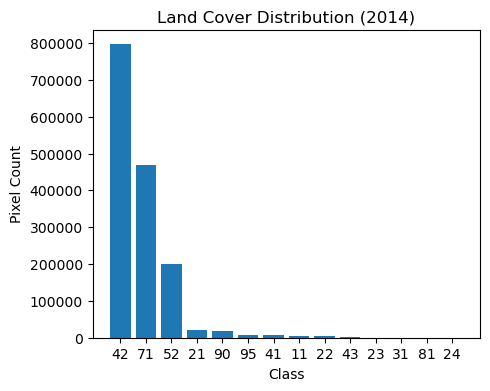

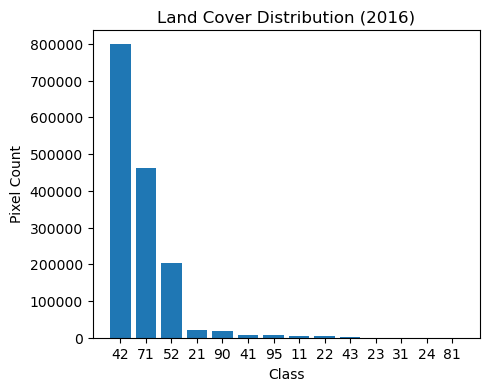

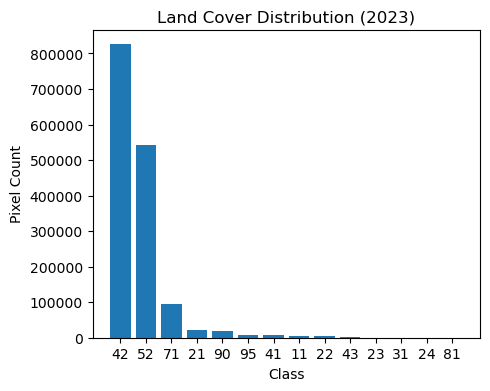

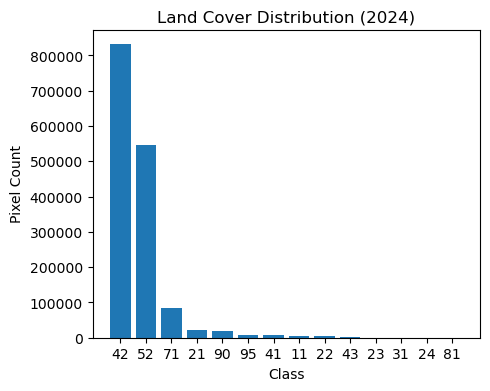

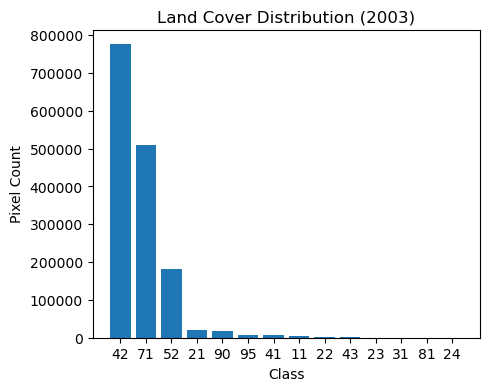

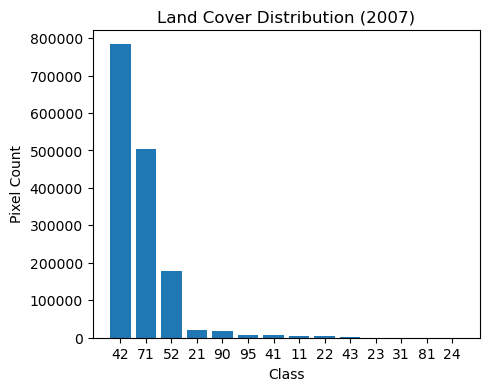

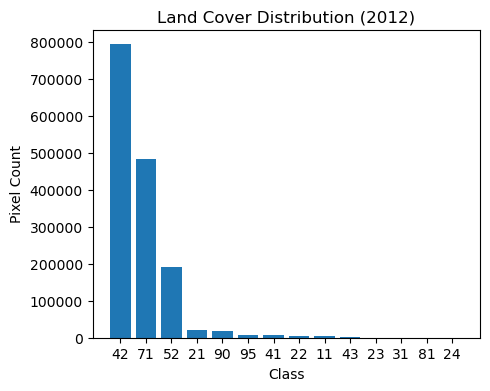

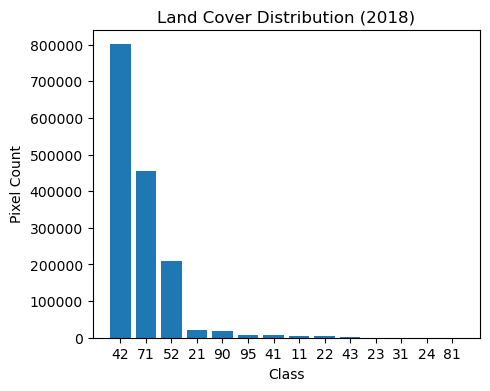

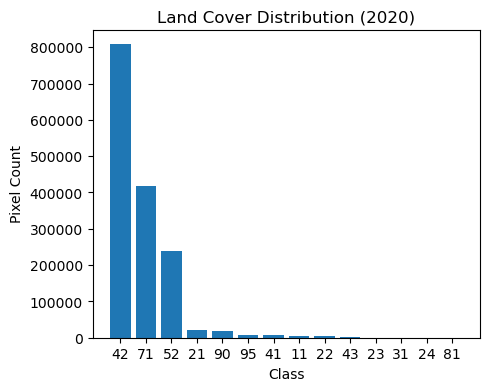

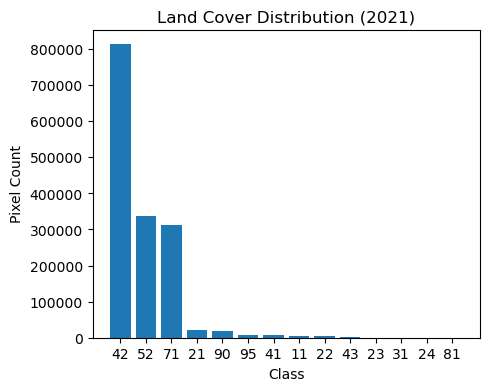

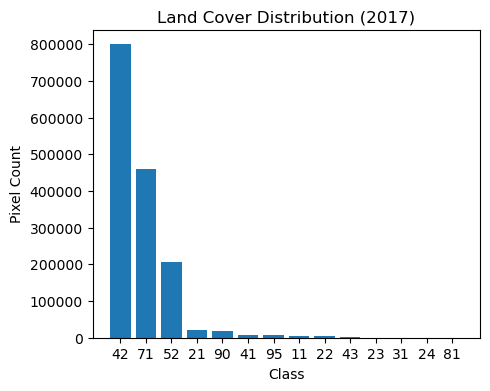

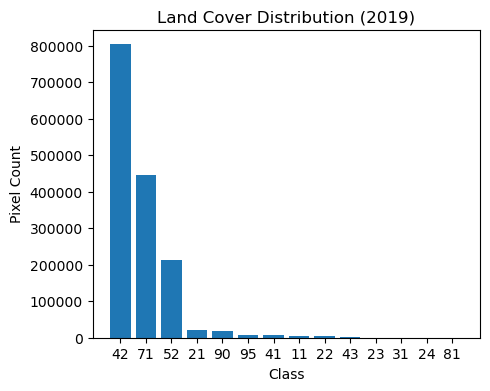

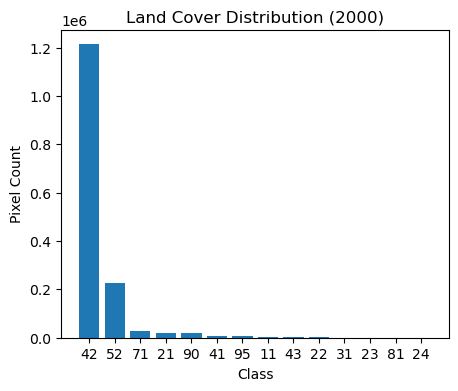

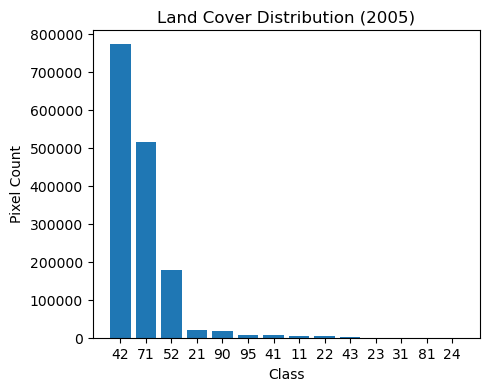

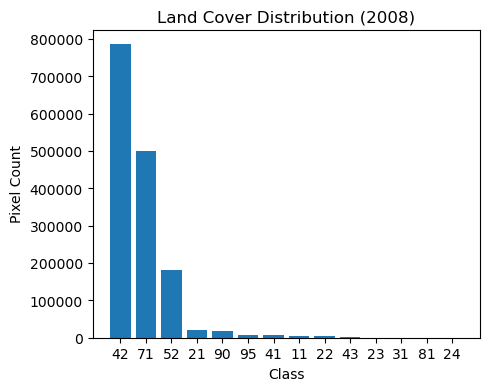

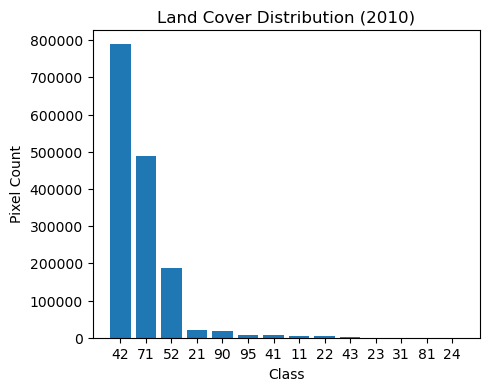

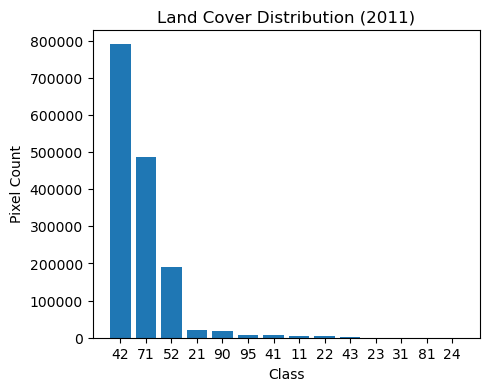

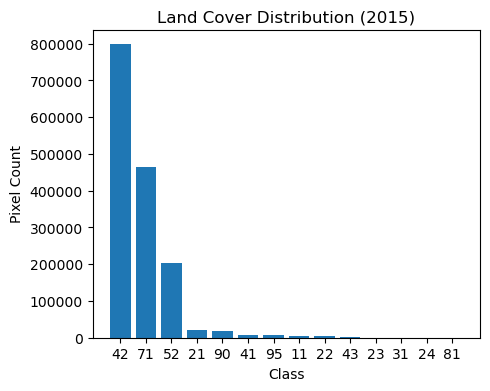

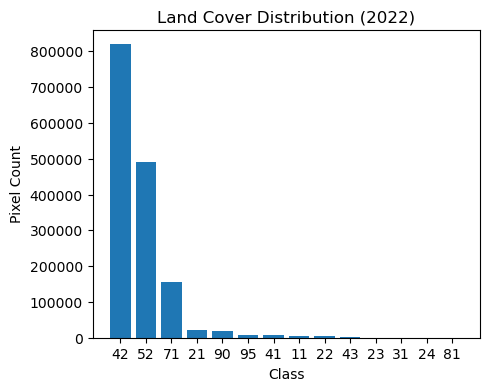

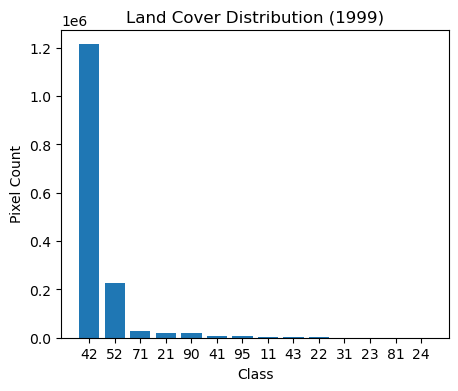

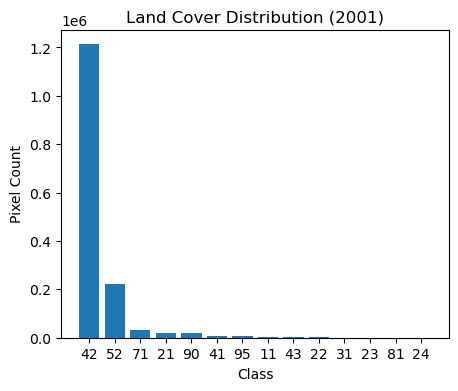

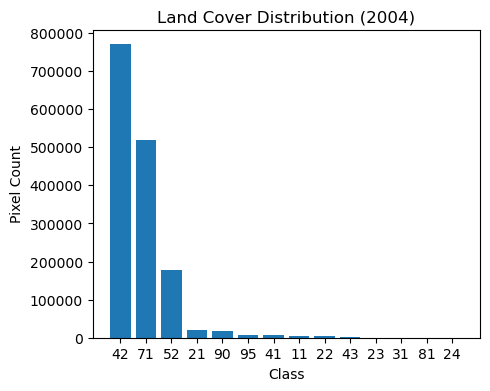

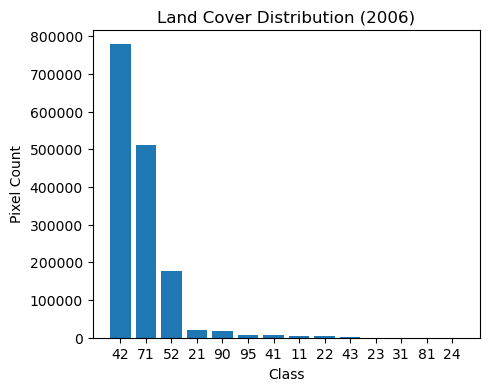

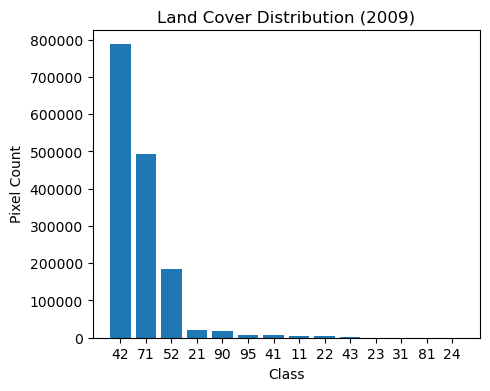

In [27]:
import matplotlib.pyplot as plt
import numpy as np

for year, da in rasters.items():  # rasters is your dict from earlier
    # flatten values and drop NaNs
    arr = da.values
    values, counts = np.unique(arr[~np.isnan(arr)], return_counts=True)

    # sort counts descending
    sorted_idx = np.argsort(-counts)
    values_sorted = values[sorted_idx].astype(int)  # cast to int for cleaner labels
    counts_sorted = counts[sorted_idx]

    # create a histogram
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar(values_sorted.astype(str), counts_sorted)
    ax.set_xlabel('Class')
    ax.set_ylabel('Pixel Count')
    ax.set_title(f'Land Cover Distribution ({year})')

    plt.show()

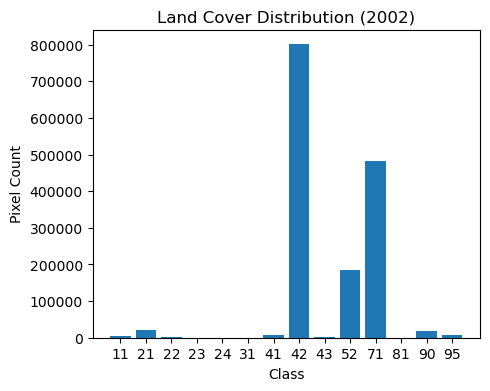

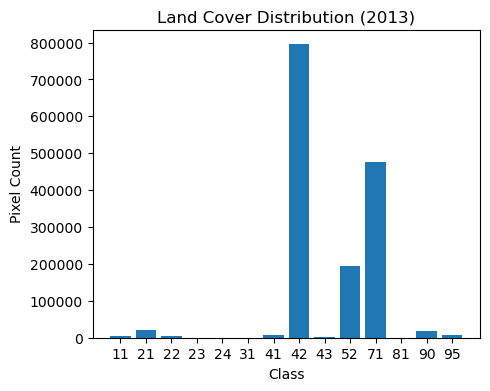

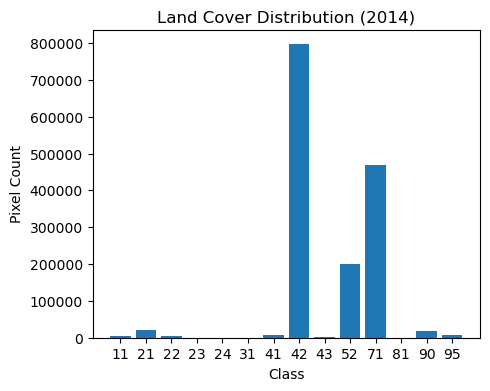

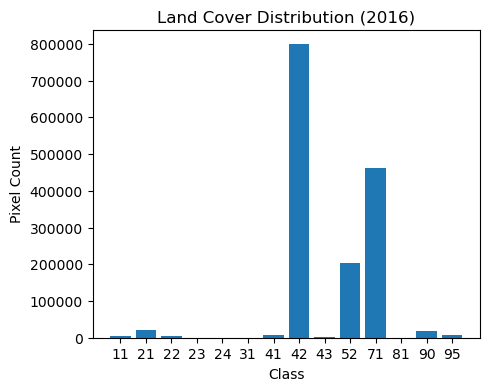

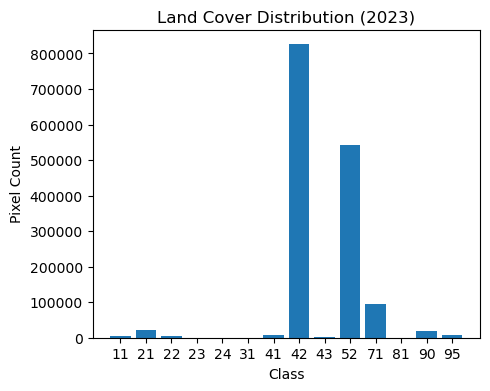

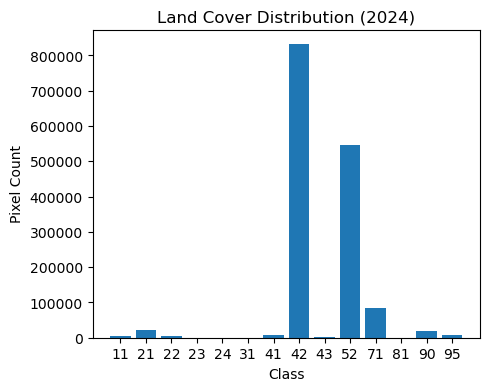

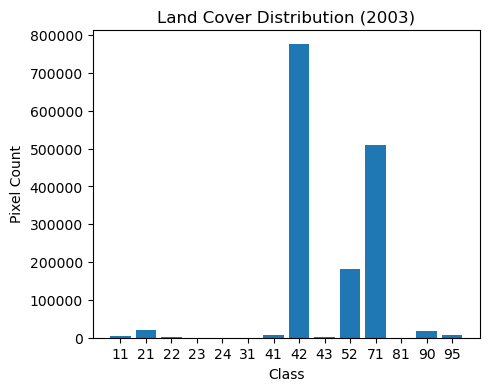

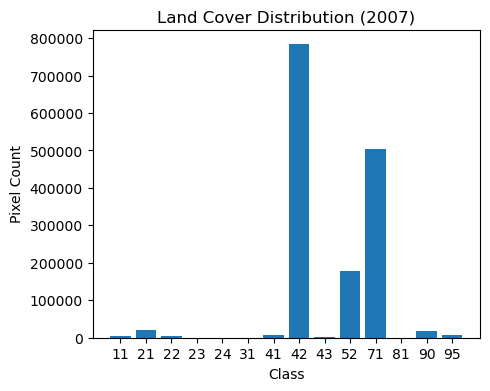

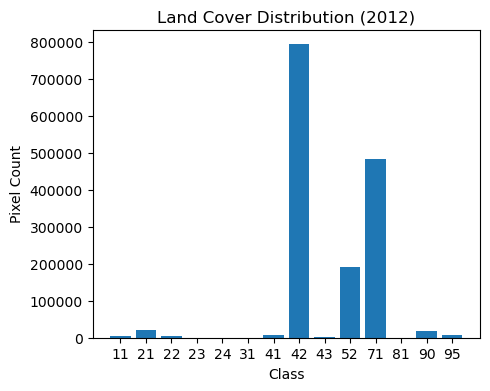

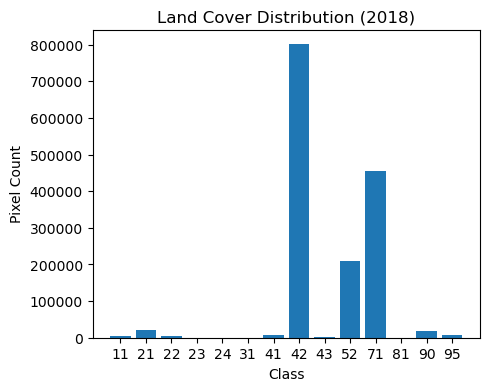

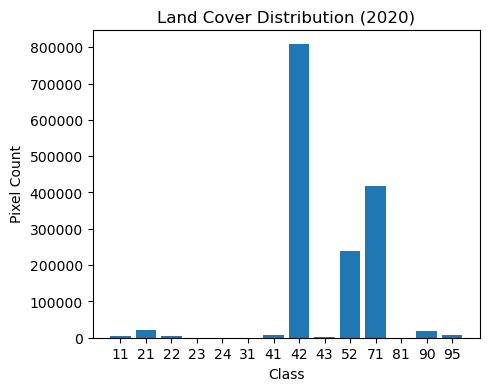

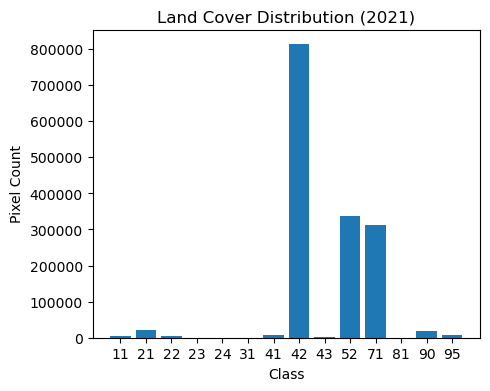

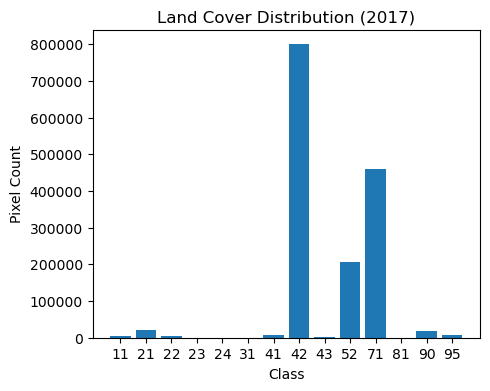

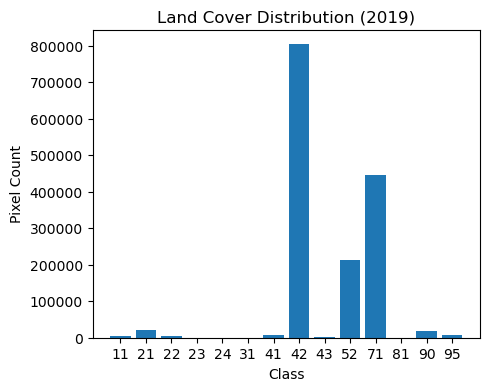

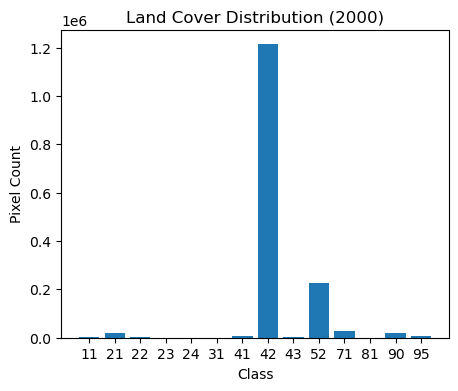

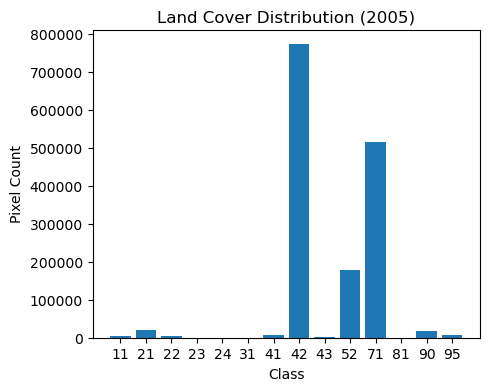

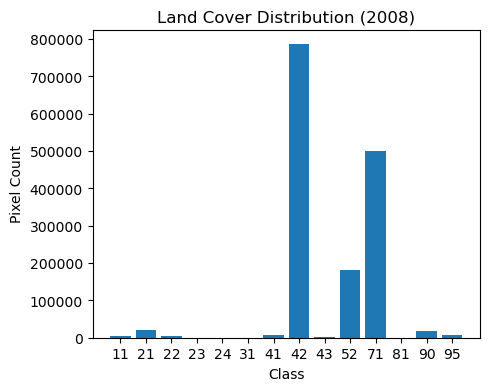

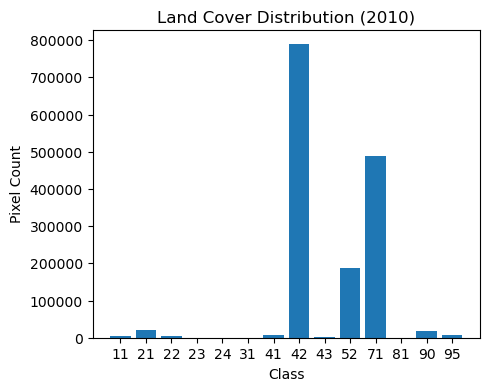

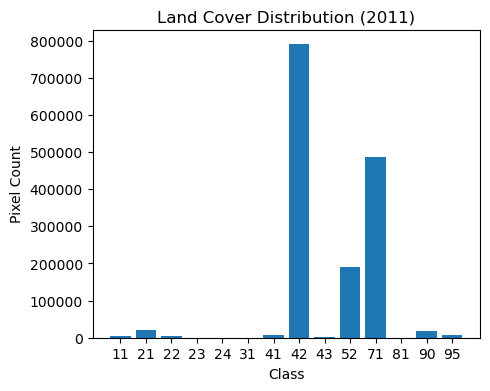

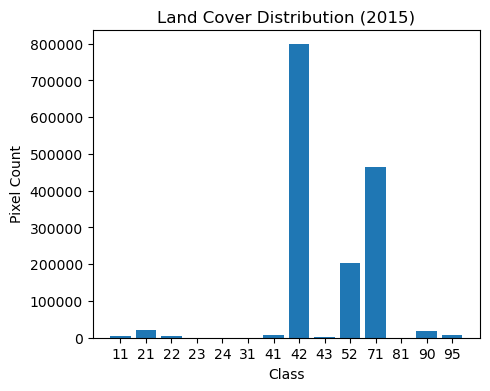

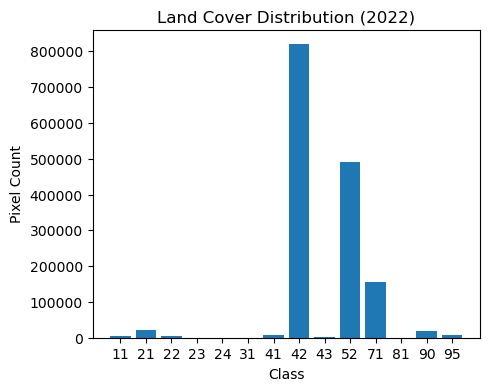

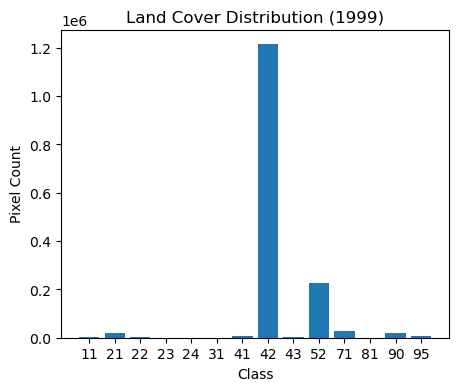

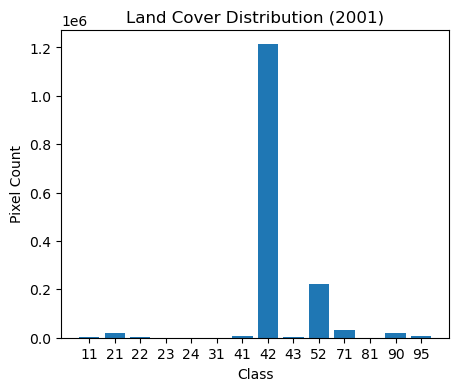

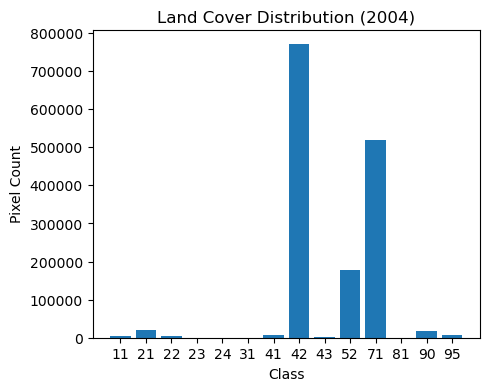

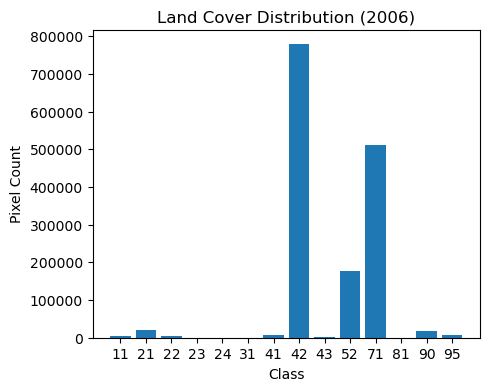

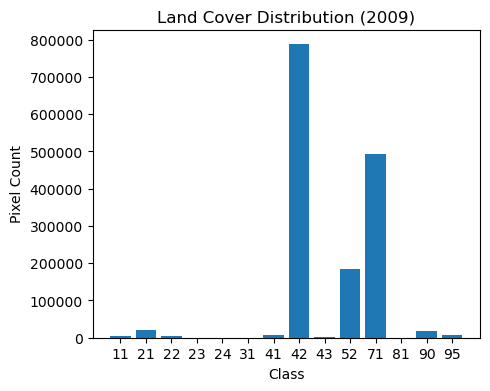

In [28]:
import matplotlib.pyplot as plt
import numpy as np

for year, da in rasters.items():
    arr = da.values
    values, counts = np.unique(arr[~np.isnan(arr)], return_counts=True)

    values_sorted = values.astype(int)
    counts_sorted = counts

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar(values_sorted.astype(str), counts_sorted)
    ax.set_xlabel('Class')
    ax.set_ylabel('Pixel Count')
    ax.set_title(f'Land Cover Distribution ({year})')
    plt.show()


/tmp/ipykernel_1619/2662251953.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


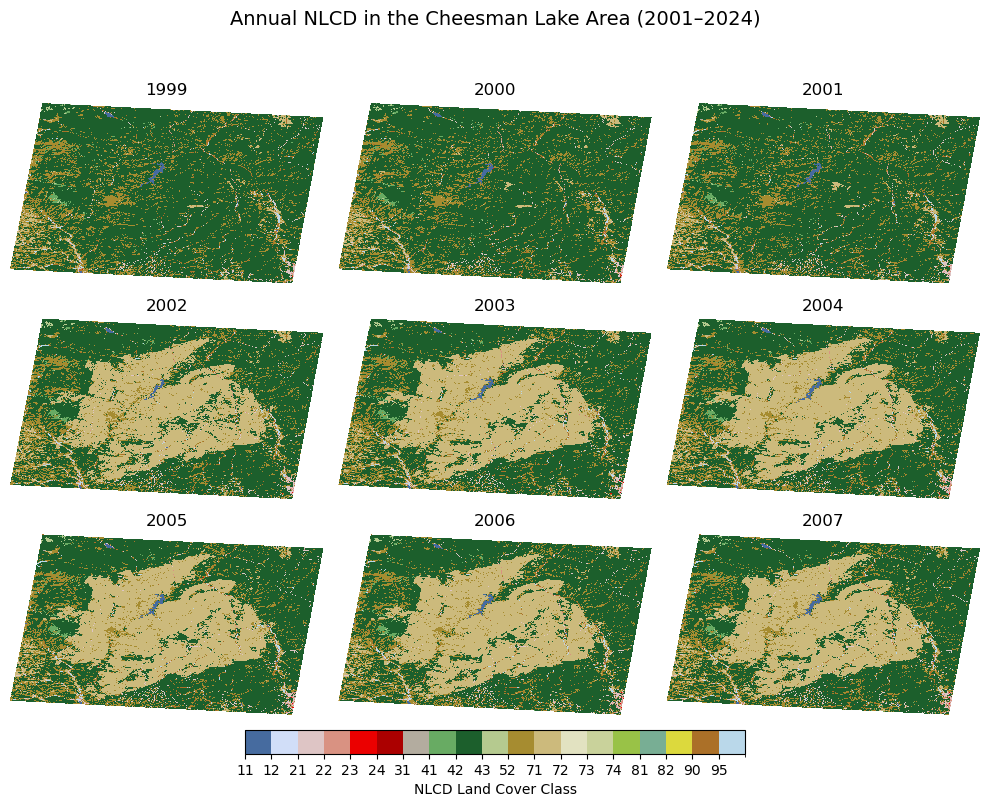

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- NLCD classes and their official USGS colors ---
nlcd_classes = [
    11, 12, 21, 22, 23, 24, 31, 41, 42, 43,
    52, 71, 72, 73, 74, 81, 82, 90, 95
]
nlcd_colors = [
    '#466b9f', '#d1def8', '#dec5c5', '#d99282', '#eb0000', '#ab0000',
    '#b3ac9f', '#68ab63', '#1c5f2c', '#b5ca8f', '#a68c30', '#ccba7c',
    '#e2e2c1', '#c9d29b', '#99c247', '#78ae94', '#dcd93d', '#ab7028',
    '#bad8ea'
]

cmap = mcolors.ListedColormap(nlcd_colors)
norm = mcolors.BoundaryNorm(nlcd_classes + [100], cmap.N)  # upper bound +1 class
levels = nlcd_classes + [100]

# --- Plot grid of rasters ---
fig, axs = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
fig.suptitle('Annual NLCD in the Cheesman Lake Area (2001–2024)', fontsize=14)

for ax, (year, da) in zip(axs.flatten(), sorted(rasters.items())):
    ax.axis('off')
    da.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
    ax.set_title(str(year))

# --- Colorbar for all subplots ---
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='horizontal',
    ticks=nlcd_classes,
    label='NLCD Land Cover Class'
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


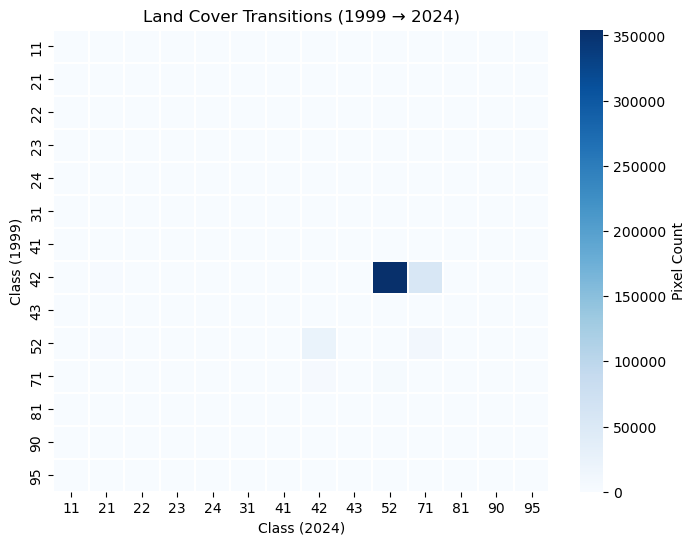

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def transition_matrix(rasters, year_start, year_end):
    """Compute and plot land cover transition matrix between two years."""
    s = rasters[str(year_start)].values.flatten()
    e = rasters[str(year_end)].values.flatten()

    # drop missing values (NaNs)
    mask = ~np.isnan(s) & ~np.isnan(e)
    s_clean = s[mask].astype(int)
    e_clean = e[mask].astype(int)

    # cross-tabulate start vs end classes
    matrix = pd.crosstab(s_clean, e_clean)

    # zero the diagonal (no-change)
    np.fill_diagonal(matrix.values, 0)

    # plot heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        matrix,
        cmap='Blues',
        linewidths=0.1,
        cbar_kws={'label': 'Pixel Count'}
    )
    ax.set_xlabel(f'Class ({year_end})')
    ax.set_ylabel(f'Class ({year_start})')
    ax.set_title(f'Land Cover Transitions ({year_start} → {year_end})')
    plt.show()

    return matrix

# Example: compare 2001 and 2024 rasters
tm = transition_matrix(rasters, 1999, 2024)


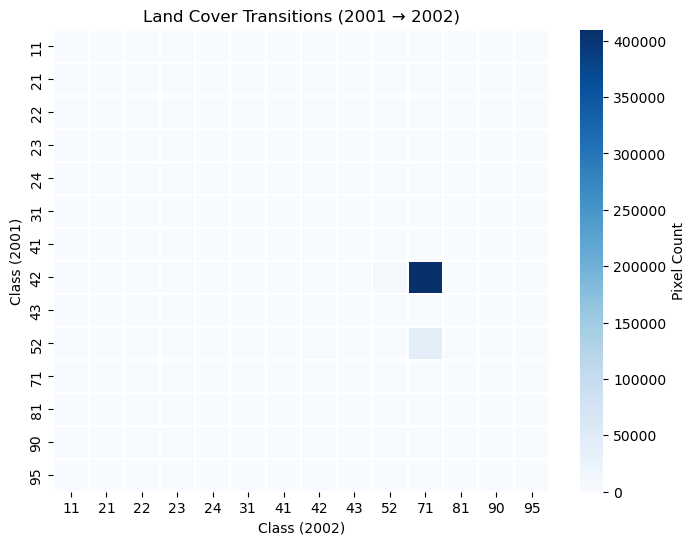

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def transition_matrix(rasters, year_start, year_end):
    """Compute and plot land cover transition matrix between two years."""
    s = rasters[str(year_start)].values.flatten()
    e = rasters[str(year_end)].values.flatten()

    # drop missing values (NaNs)
    mask = ~np.isnan(s) & ~np.isnan(e)
    s_clean = s[mask].astype(int)
    e_clean = e[mask].astype(int)

    # cross-tabulate start vs end classes
    matrix = pd.crosstab(s_clean, e_clean)

    # zero the diagonal (no-change)
    np.fill_diagonal(matrix.values, 0)

    # plot heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        matrix,
        cmap='Blues',
        linewidths=0.1,
        cbar_kws={'label': 'Pixel Count'}
    )
    ax.set_xlabel(f'Class ({year_end})')
    ax.set_ylabel(f'Class ({year_start})')
    ax.set_title(f'Land Cover Transitions ({year_start} → {year_end})')
    plt.show()

    return matrix

# Example: compare 2001 and 2024 rasters
tm = transition_matrix(rasters, 2001, 2002)


/tmp/ipykernel_1619/238998866.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


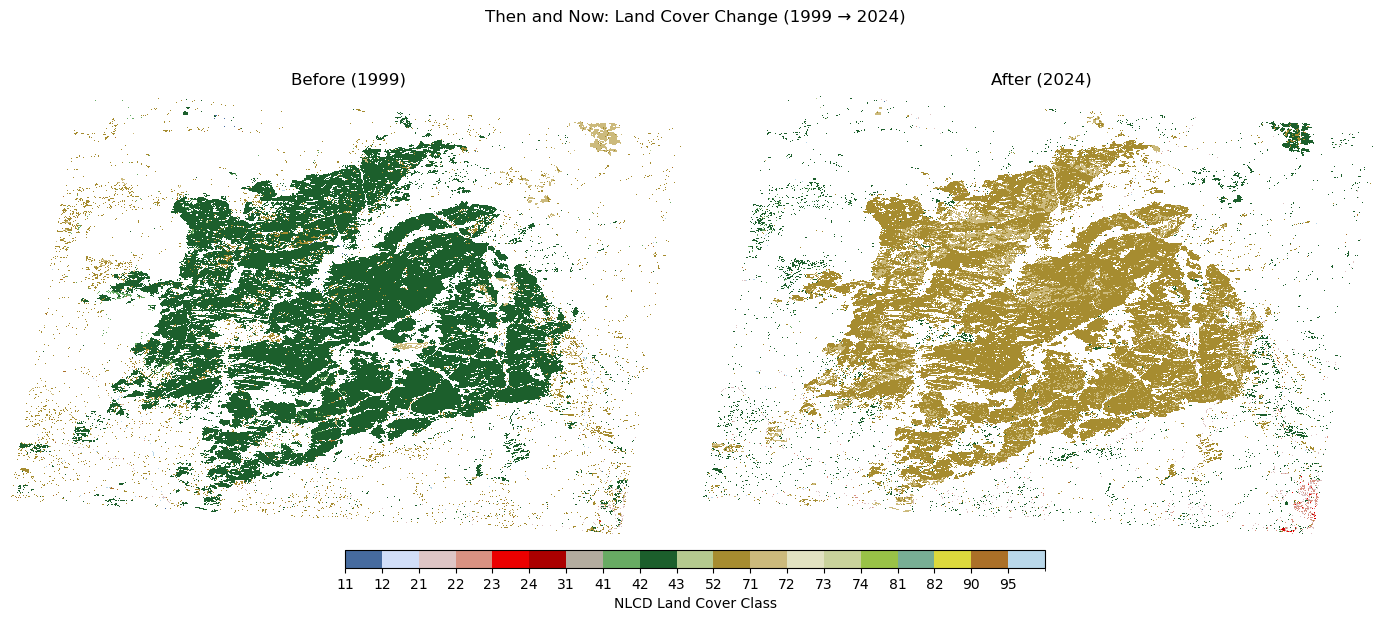

In [34]:
import matplotlib.pyplot as plt

# Pick start and end years
year_start, year_end = 1999, 2024

# Extract rasters
da_start = rasters[str(year_start)]
da_end   = rasters[str(year_end)]

# Mask where classes differ
change_start = da_start.where(da_start.values != da_end.values)
change_end   = da_end.where(da_start.values != da_end.values)

# Pack into list for plotting
diff_datasets = [change_start, change_end]
title_names = [f"Before ({year_start})", f"After ({year_end})"]

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
fig.suptitle(f"Then and Now: Land Cover Change ({year_start} → {year_end})")

for ax, title, data in zip(axs.flatten(), title_names, diff_datasets):
    data.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
    ax.axis("off")
    ax.set_title(title)

# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation="horizontal",
    ticks=levels[:-1],
    label="NLCD Land Cover Class"
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()
